<a href="https://colab.research.google.com/github/olawoyinshadrach/assessed-tasks/blob/main/Deep_Learning_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assessment

## **Step 1:** Import require libraries

In [12]:
#import dependencies
import os
from google.colab import drive
import shutil
import json
import cv2
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models


# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


## **Step 2:** Load the data from Kaggle using kaggle API and extract to colab for fast modelling

In [5]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# --- AUTHENTICATION ---
# Using the kaggle.json file
kaggle_creds = {
    "username":"shadracholawoyin",
    "key":"8b17f256767a8ba0e7db3aa207368b98"
                }

# Creating the credential file
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)
!chmod 600 ~/.kaggle/kaggle.json
print("Login credentials loaded")

Login credentials loaded


In [7]:
# Creating a folder for the dataset (permanent storage)
drive_folder = '/content/drive/My Drive/DeepLearning_Project/dataset'
drive_zip_path = os.path.join(drive_folder, 'chest-xray-pneumonia.zip')


# Path to extract data for temporary and fast training purposes
local_zip_path = '/content/chest-xray-pneumonia.zip'
local_extract_path = '/content/dataset'

In [8]:
# --- STEP 1: File download in drive ---
if not os.path.exists(drive_zip_path):
    print("Zip file missing in Drive. Downloading now...")

    # Create folder if needed
    if not os.path.exists(drive_folder):
        os.makedirs(drive_folder)

    # Download directly to Drive
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p "{drive_folder}"
    print("Download to Drive complete.")
else:
    print(f"Found zip file in Drive at {drive_zip_path}")

Found zip file in Drive at /content/drive/My Drive/DeepLearning_Project/dataset/chest-xray-pneumonia.zip


In [9]:
# Copy to Local Disk (Speed)
if not os.path.exists(local_extract_path):
    print("Copying data to local disk for speed...")
    shutil.copy(drive_zip_path, local_zip_path)

    print("Unzipping...")
    !unzip -q "{local_zip_path}" -d "{local_extract_path}"
    print("SUCCESS! Data is ready for training.")
else:
    print("Data is already unzipped and ready locally!")

Copying data to local disk for speed...
Unzipping...
SUCCESS! Data is ready for training.


## **Step 3:** Exploratory Data Analysis



1.   Class Balance Analysis (The "Bias" Check)
2.   List item



Found 5216 files belonging to 2 classes.
Class names found: ['NORMAL', 'PNEUMONIA']


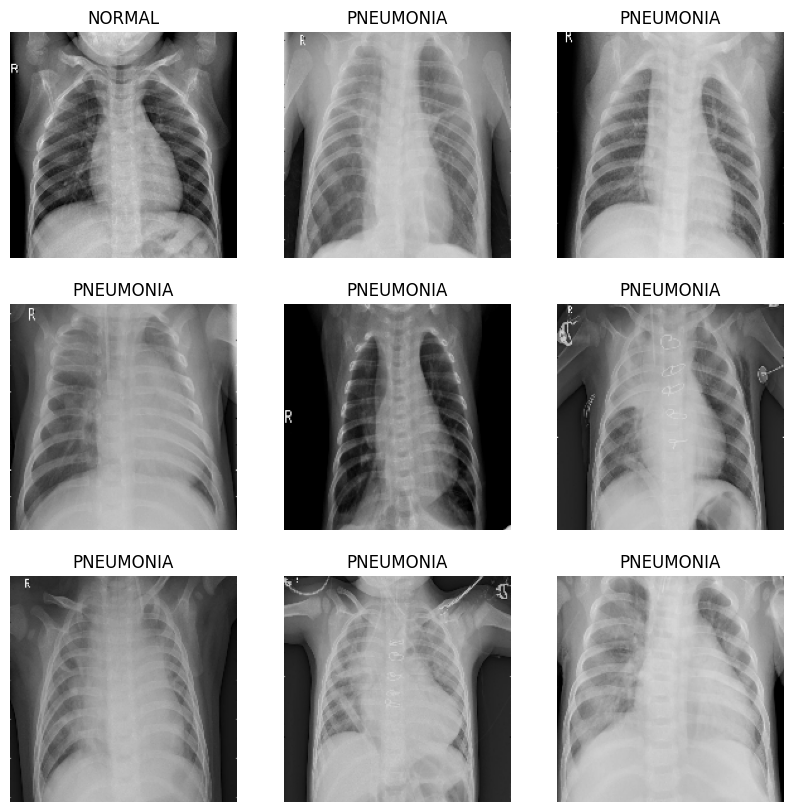

In [10]:
# Define the path to the unzipped data
data_dir = pathlib.Path('/content/dataset/chest_xray/train')

# Creating a temporary dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    image_size=(180, 180),
    batch_size=32,
    seed=123
)

# Get class names
class_names = train_ds.class_names

# Plot the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

print(f"Class names are: {class_names}")

### 3A. Class Balance Analysis (The "Bias" Check)

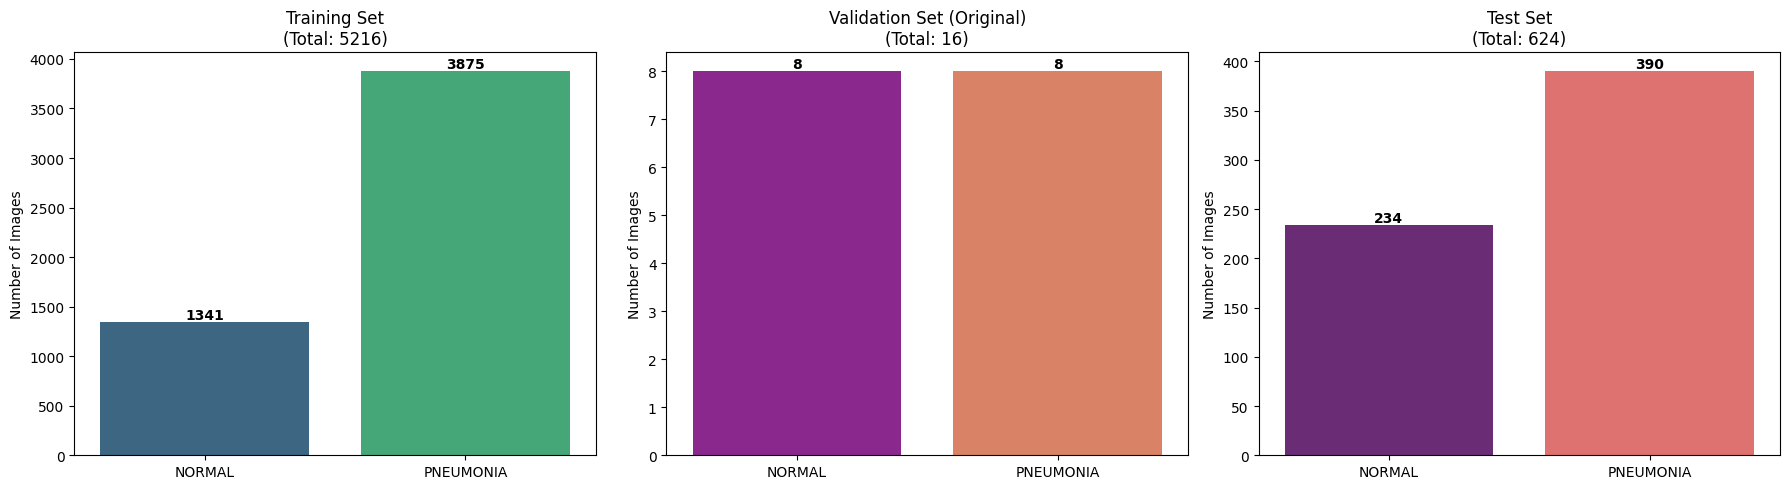

In [11]:
# Defining paths to data
base_dir = '/content/dataset/chest_xray'
categories = ['NORMAL', 'PNEUMONIA']

# Function to count images in a specific folder
def get_counts(folder_name):
    counts = []
    for cat in categories:
        path = os.path.join(base_dir, folder_name, cat)
        # Handle cases where folder might not exist or be empty
        if os.path.exists(path):
            counts.append(len(os.listdir(path)))
        else:
            counts.append(0)
    return counts

# Get counts for all three sets
train_counts = get_counts('train')
val_counts = get_counts('val')
test_counts = get_counts('test')

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
colors = ['viridis', 'plasma', 'magma'] # Different color schemes for variety

# Helper function for plotting
def plot_set(axis, counts, title, color_palette):
    sns.barplot(x=categories, y=counts, hue=categories, ax=axis, palette=color_palette, legend=False)
    axis.set_title(f'{title}\n(Total: {sum(counts)})')
    axis.set_ylabel('Number of Images')
    for i, v in enumerate(counts):
        axis.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# 1. Train Plot
plot_set(ax[0], train_counts, 'Training Set', 'viridis')

# 2. Validation Plot
plot_set(ax[1], val_counts, 'Validation Set (Original)', 'plasma')

# 3. Test Plot
plot_set(ax[2], test_counts, 'Test Set', 'magma')

plt.tight_layout()
plt.show()

* **Training:** Huge imbalance (many more Pneumonia than Normal). The model will be biased toward predicting Pneumonia.

* **Validation:** Very tiny total count. The provided validation set is statistically insignificant.

* **Test:** Also imbalanced.




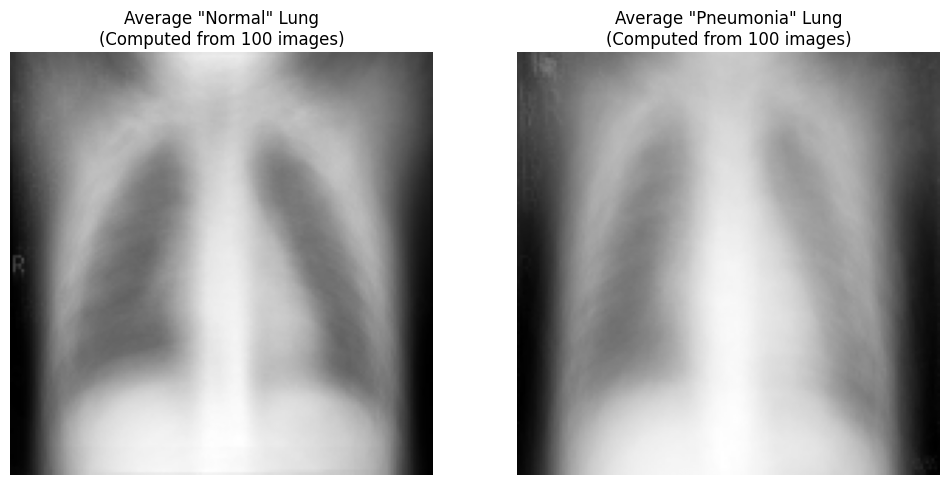

In [15]:
#Average pixel intensity analysis

def compute_average_image(folder_path, img_size=(150, 150), num_images=100):
    # Initialize a blank image
    avg_img = np.zeros(img_size, dtype=np.float32)
    count = 0

    # Get list of files
    files = os.listdir(folder_path)

    # Loop through images one by one
    for fname in files:
        if count >= num_images:
            break

        img_path = os.path.join(folder_path, fname)
        try:
            # Read and Resize (0 means Grayscale)
            img = cv2.imread(img_path, 0)
            if img is None: continue
            img = cv2.resize(img, img_size)

            # Add to our running total
            avg_img += img
            count += 1
        except Exception as e:
            pass # Pass broken images

    # Divide by count to get the average
    if count > 0:
        avg_img = avg_img / count

    return avg_img, count

# Define paths
base_dir = '/content/dataset/chest_xray/train'
normal_path = os.path.join(base_dir, 'NORMAL')
pneumonia_path = os.path.join(base_dir, 'PNEUMONIA')

avg_normal, c1 = compute_average_image(normal_path)
avg_pneumonia, c2 = compute_average_image(pneumonia_path)

# Plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(avg_normal, cmap='gray')
plt.title(f'Average "Normal" Lung\n(Computed from {c1} images)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(avg_pneumonia, cmap='gray')
plt.title(f'Average "Pneumonia" Lung\n(Computed from {c2} images)')
plt.axis('off')

plt.show()

An analysis of the average pixel intensity reveals that the Pneumonia class (Right) exhibits significantly higher opacity (whiteness) in the lower lung lobes compared to the clearer, darker definition seen in the Normal class (Left). This confirms that pixel intensity is a discriminative feature for the model to learn.



